In [4]:
import pandas as pd
import numpy as np

from nltk import word_tokenize

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import torchtext
import random

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Загрузка данных

In [6]:
 ! pip install -q kaggle

In [7]:
from google.colab import files

In [9]:
 ! mkdir /root/.kaggle

In [10]:
! cp kaggle.json /root/.kaggle

In [11]:
! chmod 600 /root/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d abhijeetbhilare/prepost-product-purchase-questions

 61% 13.0M/21.2M [00:00<00:00, 134MB/s]
100% 21.2M/21.2M [00:00<00:00, 135MB/s]


In [13]:
 !unzip prepost-product-purchase-questions.zip

Archive:  prepost-product-purchase-questions.zip
  inflating: Pre_Post_Questions.csv  


In [14]:
!ls

kaggle.json				Pre_Post_Questions.csv
prepost-product-purchase-questions.zip	sample_data


# Обзор данных

In [81]:
df = pd.read_csv('Pre_Post_Questions.csv',encoding="latin1")
df.head(10)

,id,question,item_name,label
0,B017PICGL0,Are boots cold reliable?,"Reebok Work Men's Zigkick RB7005 Work Shoe, Br...",Pre
1,B01HI8YEZS,is the main body rubber or plastic?,"3C-Aone Galaxy S5 Case,Mangix Built-in Glass L...",Pre
2,B07GZ1LF4R,Do you know the thread pitch/count for the tang?,"ColdLand |14.00"" Hand Forged Damascus Steel Bl...",Post
3,B07BMNPRFN,The item ordered came tarnished and my son nee...,BEICHUANG Beidou 7 Stars Big Dipper Star Penda...,Post
4,B075QQKFK3,"""I purchased these and now they look weird wit...",Alla Lighting H8 H11 LED Bulbs Xtreme Super Br...,Post
5,B0189R9470,How long after placing order until US delivery?,Sport/Slim Reversible Waterproof Medical Alert...,Pre
6,B07JFSCJB6,Wich one would you recommend to go with torque...,MCWAUTO Android 9.0 Car GPS Stereo for Audi A4...,Post
7,B004QYME78,Will this fit a Stern Monopoly machine?,Game Room Guys Universal Pinball Ball Shooter ...,Pre
8,B01N811J6K,what year were these knives made?,"MTech USA MT-588BK Fixed Blade Neck Knife, Bla...",Pre
9,B019PJV3N4,Is the power cord detachable?,AcuRite 75100 Large 18âEDigital LED Wall Clo...,Pre


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231904 entries, 0 to 231903
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         231904 non-null  object
 1   question   231904 non-null  object
 2   item_name  231781 non-null  object
 3   label      231600 non-null  object
dtypes: object(4)
memory usage: 7.1+ MB


In [83]:
df = df[['question', 'label']]
df['label'] = df['label'].map(lambda x: 0 if x=='Pre' else 1)

In [84]:
df.head(10)

,question,label
0,Are boots cold reliable?,0
1,is the main body rubber or plastic?,0
2,Do you know the thread pitch/count for the tang?,1
3,The item ordered came tarnished and my son nee...,1
4,"""I purchased these and now they look weird wit...",1
5,How long after placing order until US delivery?,0
6,Wich one would you recommend to go with torque...,1
7,Will this fit a Stern Monopoly machine?,0
8,what year were these knives made?,0
9,Is the power cord detachable?,0


In [85]:
df.dropna(inplace=True)

In [86]:
df.label.value_counts()

0    133456
1     98448
Name: label, dtype: int64

In [87]:
# смещения в классах не наблюдаем

In [88]:
df.to_csv('/data.csv')

# Загрузка данных в торч

In [90]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [91]:
description = torchtext.legacy.data.Field(tokenize=word_tokenize, lower=True, batch_first=True)

In [92]:
y = torchtext.legacy.data.Field(sequential=False, is_target=True, use_vocab=False)

In [93]:
data = torchtext.legacy.data.TabularDataset(path='/data.csv', format='csv', 
                                     fields={
                                         'question': ('text', description),
                                         'label': ('points', y)
                                     })

In [94]:
data

In [95]:
# скачаем библиотеку для векторных представлений word2vec 

In [96]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2022-02-27 16:14:00--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.1’

wiki-news-300d-1M.v 100%[===================>] 650.22M  59.0MB/s    in 14s     

2022-02-27 16:14:14 (48.0 MB/s) - ‘wiki-news-300d-1M.vec.zip.1’ saved [681808098/681808098]



In [97]:
!ls

kaggle.json				wiki-news-300d-1M.vec
prepost-product-purchase-questions.zip	wiki-news-300d-1M.vec.zip
Pre_Post_Questions.csv			wiki-news-300d-1M.vec.zip.1
sample_data


In [98]:
!unzip 'wiki-news-300d-1M.vec.zip'

Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wiki-news-300d-1M.vec   
A



In [108]:
description.build_vocab(data)

In [109]:
!ls

kaggle.json				wiki-news-300d-1M.vec
prepost-product-purchase-questions.zip	wiki-news-300d-1M.vec.zip
Pre_Post_Questions.csv			wiki-news-300d-1M.vec.zip.1
sample_data


In [110]:
description.vocab.load_vectors(torchtext.vocab.Vectors('wiki-news-300d-1M.vec'))

In [111]:
description.vocab.vectors.shape

torch.Size([78757, 300])

In [112]:
type(data)

torchtext.legacy.data.dataset.TabularDataset

In [113]:
train, val = data.split(split_ratio= 0.8)

In [114]:
len(train)

185523

In [115]:
len(val)

46381

# Бейслайн


In [116]:
# рассмотрим наивный Байес

In [117]:
y = df.label
x = df.question

In [122]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [120]:
cv = CountVectorizer()
X = cv.fit_transform(x)
cv.get_feature_names()[:5]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00', '000', '0000', '00000', '00003']

In [123]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [124]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train,y_train)
clf.score(x_test,y_test)

0.7403031413725448

# Формирование сети LSTM+W2V

In [125]:
class lstm(nn.Module):
    def __init__(self, w2v, padding_inx, dropout, hidden_size):
        super(lstm, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(w2v)
        self.embedding.padding_inx = padding_inx

        self.embedding.weight.requires_grad = True

        self.dropout = nn.Dropout(p = dropout)
        self.lstm = nn.LSTM(input_size = self.embedding.embedding_dim,
                            hidden_size = hidden_size,
                            num_layers = 2,
                            dropout = dropout,
                            bidirectional = True)
        self.label = nn.Linear(hidden_size*2*2, 1)

    def forward(self, sentence):
        x = self.embedding(sentence)
        x = torch.transpose(x, dim0 = 1, dim1 = 0)
        out, (hidden, c) = self.lstm(x)
        x = self.dropout(torch.cat([c[i,:,:] for i in range(c.shape[0])], dim=1))
        x = self.label(x)
        return x

In [126]:
batch_size = 64
train_i = torchtext.legacy.data.BucketIterator(dataset=train,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        sort = False,
                                        train =True)


val_i = torchtext.legacy.data.BucketIterator(dataset=val,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        sort = False,
                                        train = False)

In [127]:
from torch import optim

In [128]:
model = lstm(description.vocab.vectors, description.vocab.stoi[description.pad_token], dropout = 0.2, hidden_size=128).cuda()

In [129]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [130]:
loss = nn.BCEWithLogitsLoss()

In [131]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [132]:
def train(epochs, model, eval_time, loss_f, optimizer, train_i, val_i):
    step = 0

    losses = []
    val_losses = []

    accuracy = []
    val_accuracy = []

    train_i.init_epoch()
    for epoch in range(epochs):
        for batch in iter(train_i):
            step += 1
            model.train()
            x = batch.text.cuda()
            y = batch.points.type(torch.Tensor).cuda()

            model.zero_grad()
            preds = model.forward(x).view(-1)
            loss = loss_f(preds, y)
            losses.append(loss.cpu().data.numpy())
            accuracy.append(accuracy_score(batch.points.data.numpy().tolist(), 
                                           np.round(np.array( torch.sigmoid(preds).cpu().data.numpy().tolist()) )) 
            )
                                           

            loss.backward()
            optimizer.step()

            if step % eval_time == 0:
                clear_output(True)
                model.eval()
                model.zero_grad()
                # val_loss = []

                for batch in iter(val_i):
                    x = batch.text.cuda()
                    y = batch.points.type(torch.Tensor).cuda()

                    preds = model.forward(x).view(-1)
                    val_losses.append(loss_f(preds, y).cpu().data.numpy())
                
                    val_accuracy.append(accuracy_score(batch.points.data.numpy().tolist(), 
                                                   np.round(np.array( torch.sigmoid(preds).cpu().data.numpy().tolist() ))
                                                   ))


                fig, axs = plt.subplots(2, 2, figsize=(10, 10))
                fig.suptitle('Accuracy & Loss')
                
                axs[0, 0].set_title('train cross-entropy loss')
                axs[0, 1].set_title('test cross-entropy loss')
                axs[1, 0].set_title('train accuracy')
                axs[1, 1].set_title('test accuracy')

                axs[0, 0].plot(losses)
                axs[0, 0].plot(pd.Series(losses).rolling(400).mean().values)
                axs[0, 1].plot(val_losses)
                axs[0, 1].plot(pd.Series(val_losses).rolling(400).mean().values)
                axs[1, 0].plot(accuracy)
                axs[1, 0].plot(pd.Series(accuracy).rolling(400).mean().values)
                axs[1, 1].plot(val_accuracy)
                axs[1, 1].plot(pd.Series(val_accuracy).rolling(400).mean().values)
                
                

                for ax in axs.flat:
                    ax.set(xlabel='step')
                    # axs[0, 0].xaxis.set_ticks(np.arange(0, epochs, 1/len(losses)))
                plt.show()

                # print(f'Эпоха {epoch}, Шаг {step}, train_loss {np.array(losses).mean()}, valid_loss {np.array(val_loss).mean()}')
            

In [134]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [140]:
model.to(device)

lstm(
  (embedding): Embedding(78757, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2, bidirectional=True)
  (label): Linear(in_features=512, out_features=1, bias=True)
)

# Обучение сети

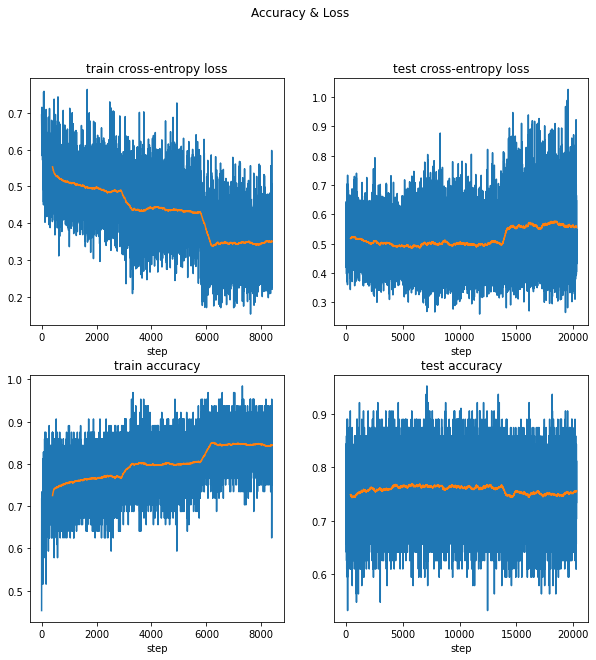

In [141]:
train(3, model, 300, loss, optimizer, train_i, val_i)

In [142]:
model.eval()

real = []
preds = []

for batch in iter(val_i):
    x = batch.text.cuda()
    # y = batch.points.type(torch.Tensor).cuda()
    
    real += batch.points.data.numpy().tolist()
    preds += torch.sigmoid(model.forward(x).view(-1)).cpu().data.numpy().tolist()

# Результаты

In [144]:
print(classification_report(real, np.round(np.array(preds))))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80     26653
           1       0.75      0.63      0.69     19728

    accuracy                           0.76     46381
   macro avg       0.76      0.74      0.74     46381
weighted avg       0.76      0.76      0.75     46381



In [147]:
# в целом lstm + w2v для данной задачи показал результат ненамного лучше, чем наивный Байес (0.76 vs 0.74)
# что можно доделать в будущем:
# -обучить больше эпох
# -применить трансформер